# Import necessary packages

In [1]:
import pathlib
import glob
import os

import matplotlib.pyplot as plt

from helpers.Vehicle import Vehicle
from helpers.Gaze import Gaze

# Set variables and prepare data

In [2]:
RUN_IDX = 5 # e.g., run_{RUN_IDX}
N_LAPS = 10

SAVE_DIR = pathlib.Path(".").joinpath(f"run_{RUN_IDX}").absolute()
GAZE_DIR = pathlib.Path(max(glob.glob(os.path.join(SAVE_DIR, '*/')), key=os.path.getmtime))

PATH_GAZE = GAZE_DIR.joinpath("gaze_positions.csv")
PATH_BLINK = GAZE_DIR.joinpath("blinks.csv")

PATH_VEHICLE = SAVE_DIR.joinpath("df_vehicle.csv")

print(PATH_GAZE)
print(PATH_VEHICLE)

gaze = Gaze(PATH_GAZE, PATH_BLINK)
vehicle = Vehicle(PATH_VEHICLE, N_LAPS)

c:\Users\yl39846\BAAR\run_5\000\gaze_positions.csv
c:\Users\yl39846\BAAR\run_5\df_vehicle.csv


In [3]:
veh_lap_end_idx = vehicle.find_veh_lap_end_idx()
gaze_lap_end_idx = vehicle.find_gaze_lap_end_idx(gaze.get_df())

print(veh_lap_end_idx)
print(gaze_lap_end_idx)

Index([57456, 117900, 176634, 236026, 295277, 347358, 406069, 469455, 524573,
       578918],
      dtype='int64')
Index([33979, 48026, 62964, 78365, 93728, 106970, 122178, 138689, 147948,
       147948],
      dtype='int64')


# Visualize data

In [4]:
def find_stop_point(df_vehicle, start_idx, end_idx, e=0.1):
    """
    This function finds stoppoing point of the vehicle and returns the corresponding norm_idx.
        Stopping point is defined when the vehicle speed is less than 0.1 km/h.

    Returns:
        norm_idx: The result of the operation.
    """
    total_interval = end_idx - start_idx
    window_start_idx = start_idx + int(total_interval * 0.25)
    window_end_idx   = start_idx + int(total_interval * 0.75)
    norm_idx = df_vehicle['v_x_Vehicle_CoG[km|h]'][window_start_idx:window_end_idx].lt(e).idxmax()
    
    return norm_idx

def section_idx(start_idx, end_idx):
    # TODO - add options to choose corner etc...
    total_interval = end_idx - start_idx
    start_idx = start_idx + int(total_interval * 0.0)
    end_idx = start_idx + int(total_interval * 1.0)
    
    return start_idx, end_idx

def get_intervals(idx):
    idx_lst = []
    for i in range(len(idx)):
        if i == 0:
            idx_lst.append((0, idx[i]))
        else:   
            idx_lst.append((idx[i-1]+1, idx[i]))

    return idx_lst

lap_idx = get_intervals(veh_lap_end_idx)
gaze_lap_idx = get_intervals(gaze_lap_end_idx)

df_vehicle = vehicle.get_df()
df_gaze = gaze.get_df()

In [11]:
print(vehicle.get_df()["time_real"].describe())
print(gaze.get_df()["gaze_timestamp"].describe())

count    605416.000000
mean        430.530442
std         199.574780
min          95.732525
25%         254.266317
50%         429.729749
75%         604.351073
max         777.569851
Name: time_real, dtype: float64


KeyError: 'gaze_time'

In [13]:
df_gaze.columns

Index(['gaze_timestamp', 'confidence', 'norm_pos_x', 'norm_pos_y',
       'gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z'],
      dtype='object')

## Distance domain normalization

### Action & Forward velocity

Normalized index: 14364
Lap 1: 0.007326399127486049

Normalized index: 83706
Lap 2: 703.7847295304891

Normalized index: 141374
Lap 3: 1408.6450276298576

Normalized index: 201602
Lap 4: 2092.7103149247437

Normalized index: 260437
Lap 5: 2795.1387759518957

Normalized index: 316508
Lap 6: 3492.56563401243

Normalized index: 370472
Lap 7: 4191.576788651067

Normalized index: 435181
Lap 8: 4890.807768144954

Normalized index: 492228
Lap 9: 5585.627129604348

Normalized index: 546403
Lap 10: 6285.400402471078



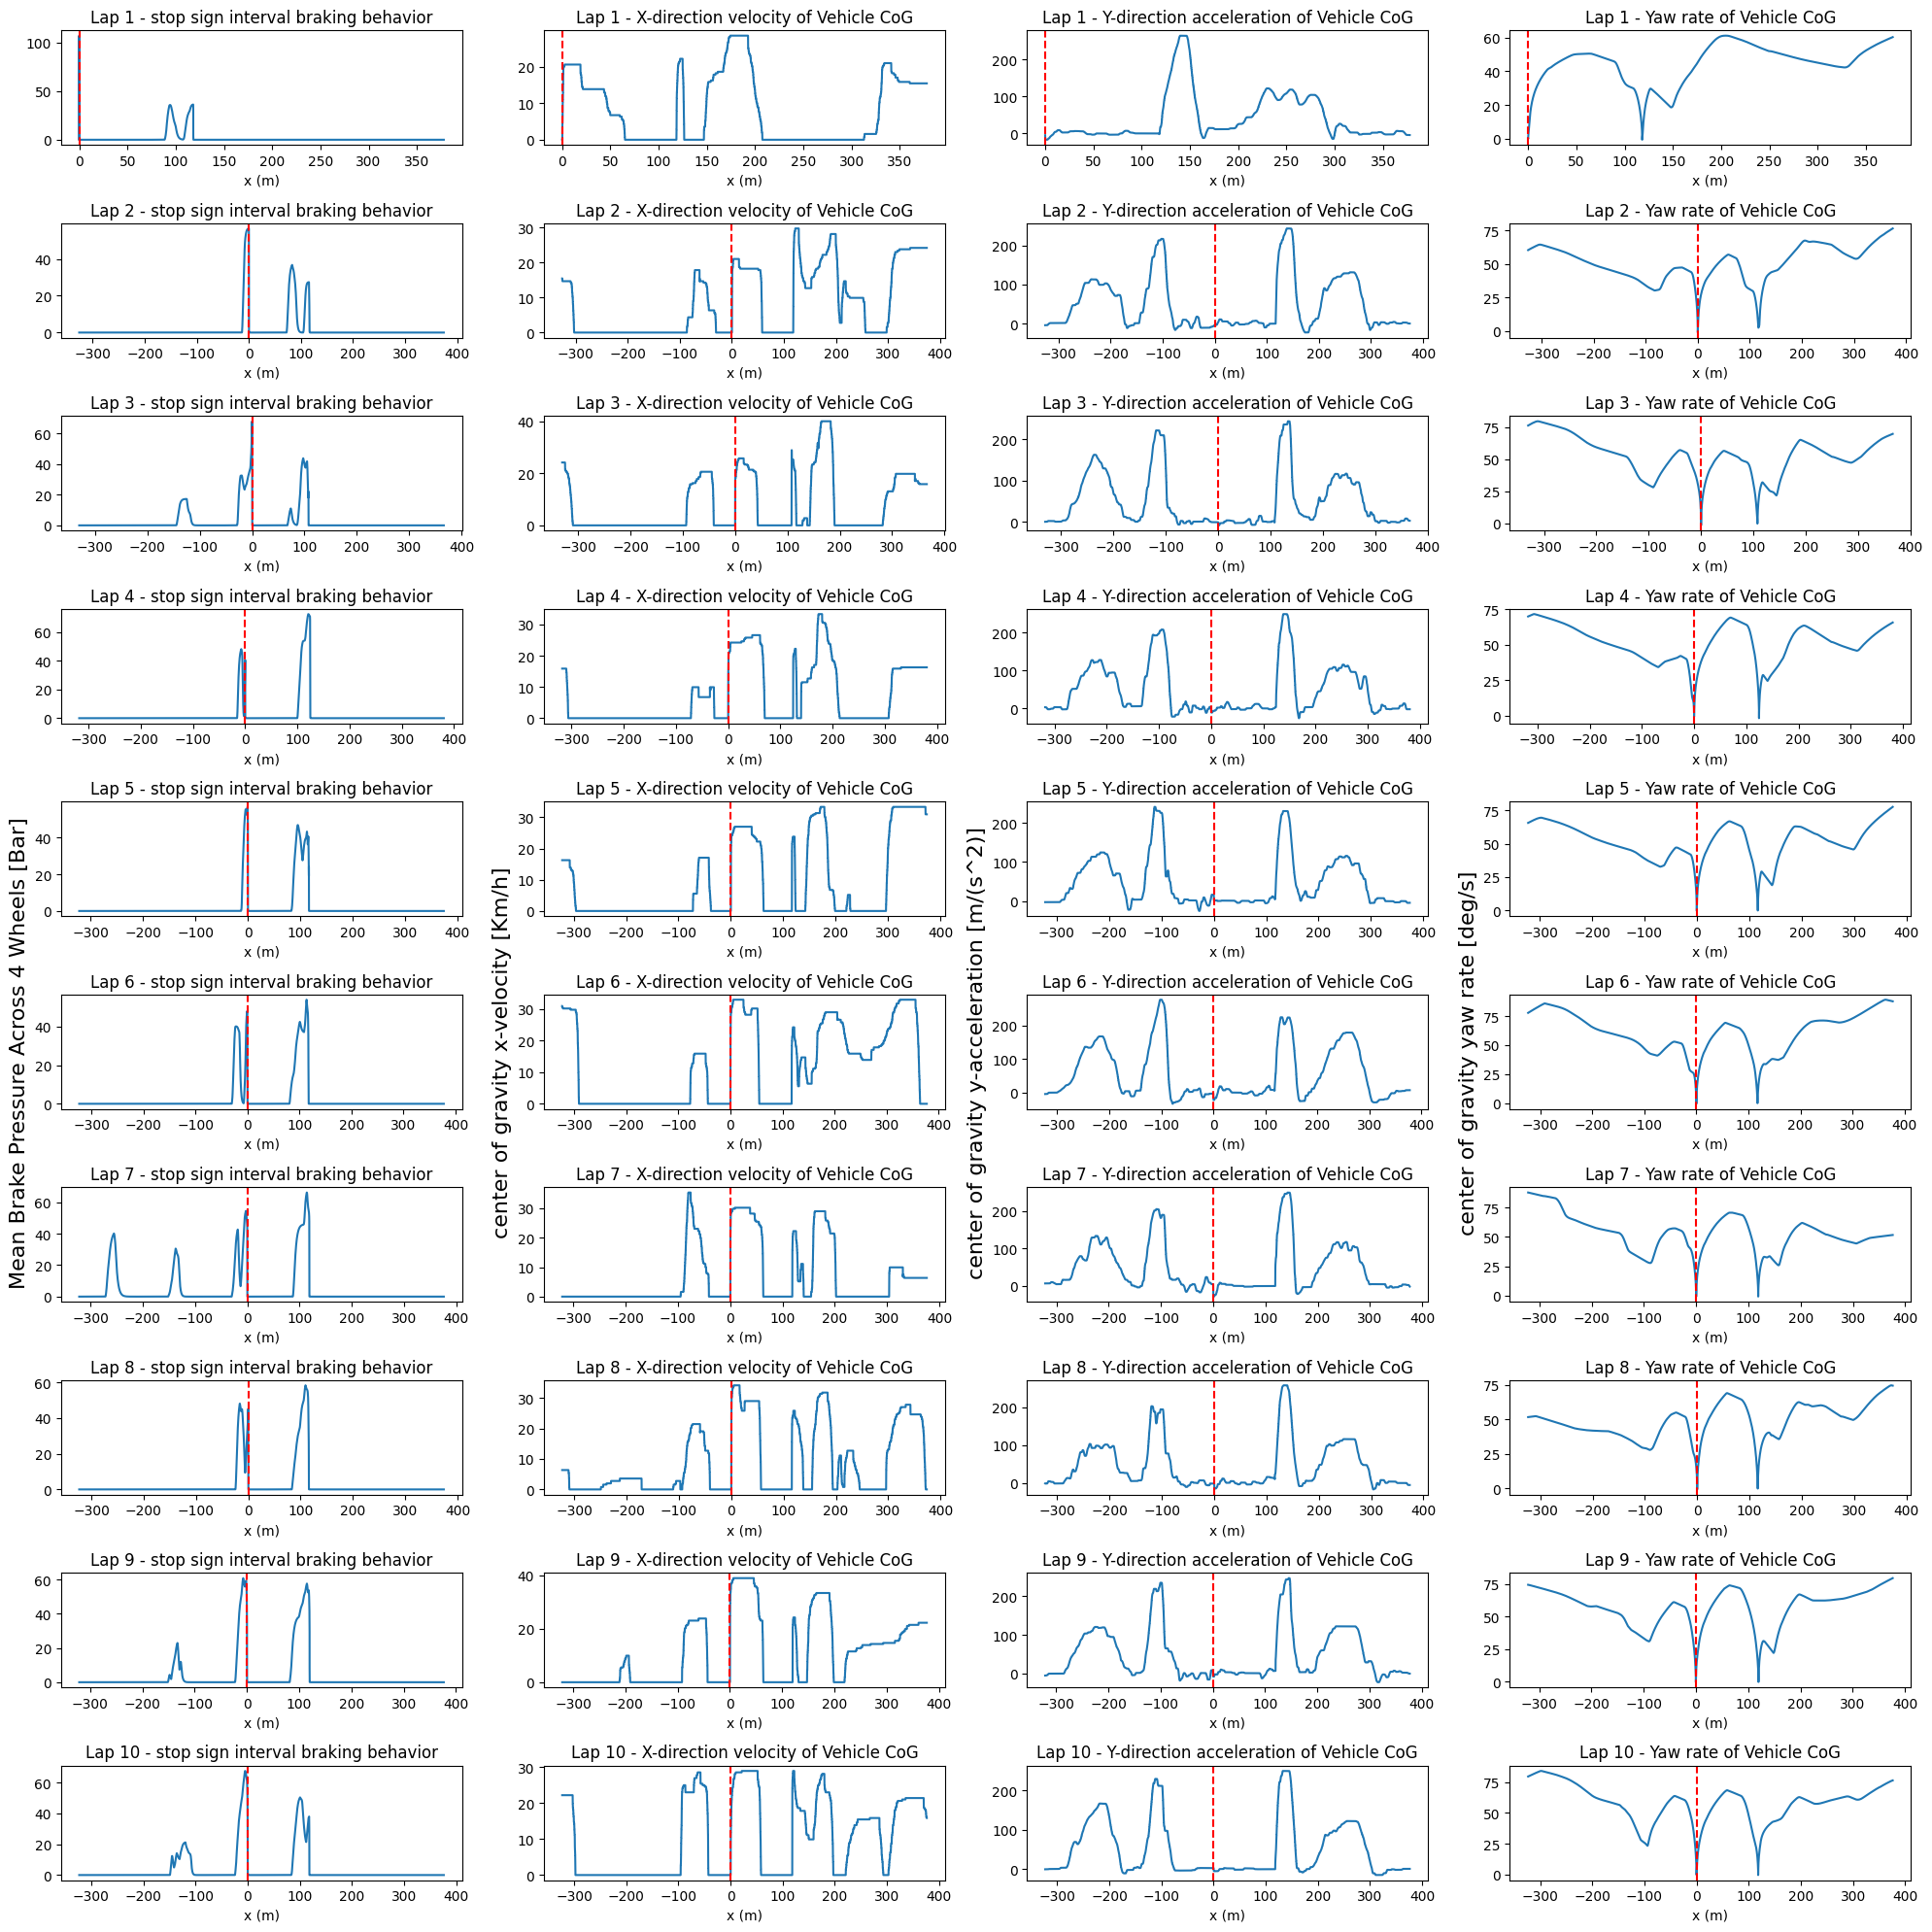

In [6]:
column_labels = ['Brake[Bar]_avg', 'Pos_AccPedal___', 'Angle_SteeringWheel_deg_', 'v_x_Vehicle_CoG[km|h]']


fig, axs = plt.subplots(N_LAPS, len(column_labels), figsize=(20, 20))

for i in range(N_LAPS):
    
    # lap interval
    start_idx, end_idx = lap_idx[i][0], lap_idx[i][1]
    gaze_start_idx, gaze_end_idx = gaze_lap_idx[i][0], gaze_lap_idx[i][1]
    norm_idx = find_stop_point(df_vehicle, start_idx, end_idx, e=0.5) # normalization w.r.t. speed < e
    print("Normalized index:", norm_idx)
    # ts_vehicle = df_vehicle['time_real'].iloc(norm_idx)
    # gaze_norm_idx = gaze.find_closest_ts_idx(ts_vehicle)
    
    # sectioned interval. (e.g., turning corner, section before/after stop sign, etc.)
    start_idx, end_idx = section_idx(start_idx, end_idx)
    gaze_start_idx, gaze_end_idx = section_idx(gaze_start_idx, gaze_end_idx)

    x = df_vehicle['s'][start_idx:end_idx] - df_vehicle['s'][norm_idx]

    print(f"Lap {i+1}: {df_vehicle['s'][norm_idx]}")
    # print(x)

    # Column data
    brake_pressure = df_vehicle[column_labels[0]][start_idx:end_idx]
    v_x            = df_vehicle[column_labels[1]][start_idx:end_idx]
    a_y            = df_vehicle[column_labels[2]][start_idx:end_idx]
    yaw            = df_vehicle[column_labels[3]][start_idx:end_idx]
    vline          = 0 # df_vehicle['x'][norm_idx]

    # Plot brake pressure
    axs[i, 0].plot(x, brake_pressure, label=f'Lap {i+1}')
    axs[i, 0].set_title(f'Lap {i+1} - stop sign interval braking behavior')
    axs[i, 0].axvline(x=vline, color='red', linestyle='--')
  
    # Plot velocity
    axs[i, 1].plot(x, v_x, label=f'Lap {i+1}')
    axs[i, 1].set_title(f'Lap {i+1} - X-direction velocity of Vehicle CoG')
    axs[i, 1].axvline(x=vline, color='red', linestyle='--')

    # Plot acceleration
    axs[i, 2].plot(x, a_y, label=f'Lap {i+1}')
    axs[i, 2].set_title(f'Lap {i+1} - Y-direction acceleration of Vehicle CoG')
    axs[i, 2].axvline(x=vline, color='red', linestyle='--')

    #Plot Yaw rate
    axs[i, 3].plot(x, yaw, label=f'Lap {i+1}')
    axs[i, 3].set_title(f'Lap {i+1} - Yaw rate of Vehicle CoG')
    axs[i, 3].axvline(x=vline, color='red', linestyle='--')

    # Set common labels
    for j in range(len(column_labels)):
        axs[i, j].set_xlabel('x (m)')

    print()

axs[5, 0].set_ylabel('Mean Brake Pressure Across 4 Wheels [Bar]', fontsize = 16)
axs[5, 1].set_ylabel('center of gravity x-velocity [Km/h]', fontsize = 16)
axs[5, 2].set_ylabel('center of gravity y-acceleration [m/(s^2)]', fontsize = 16)
axs[5, 3].set_ylabel('center of gravity yaw rate [deg/s]', fontsize = 16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Normalized index: 14364
Lap 1: 0.007326399127486049

Normalized index: 83706
Lap 2: 703.7847295304891

Normalized index: 141374
Lap 3: 1408.6450276298576

Normalized index: 201602
Lap 4: 2092.7103149247437

Normalized index: 260437
Lap 5: 2795.1387759518957

Normalized index: 316508
Lap 6: 3492.56563401243

Normalized index: 370472
Lap 7: 4191.576788651067

Normalized index: 435181
Lap 8: 4890.807768144954

Normalized index: 492228
Lap 9: 5585.627129604348

Normalized index: 546403
Lap 10: 6285.400402471078



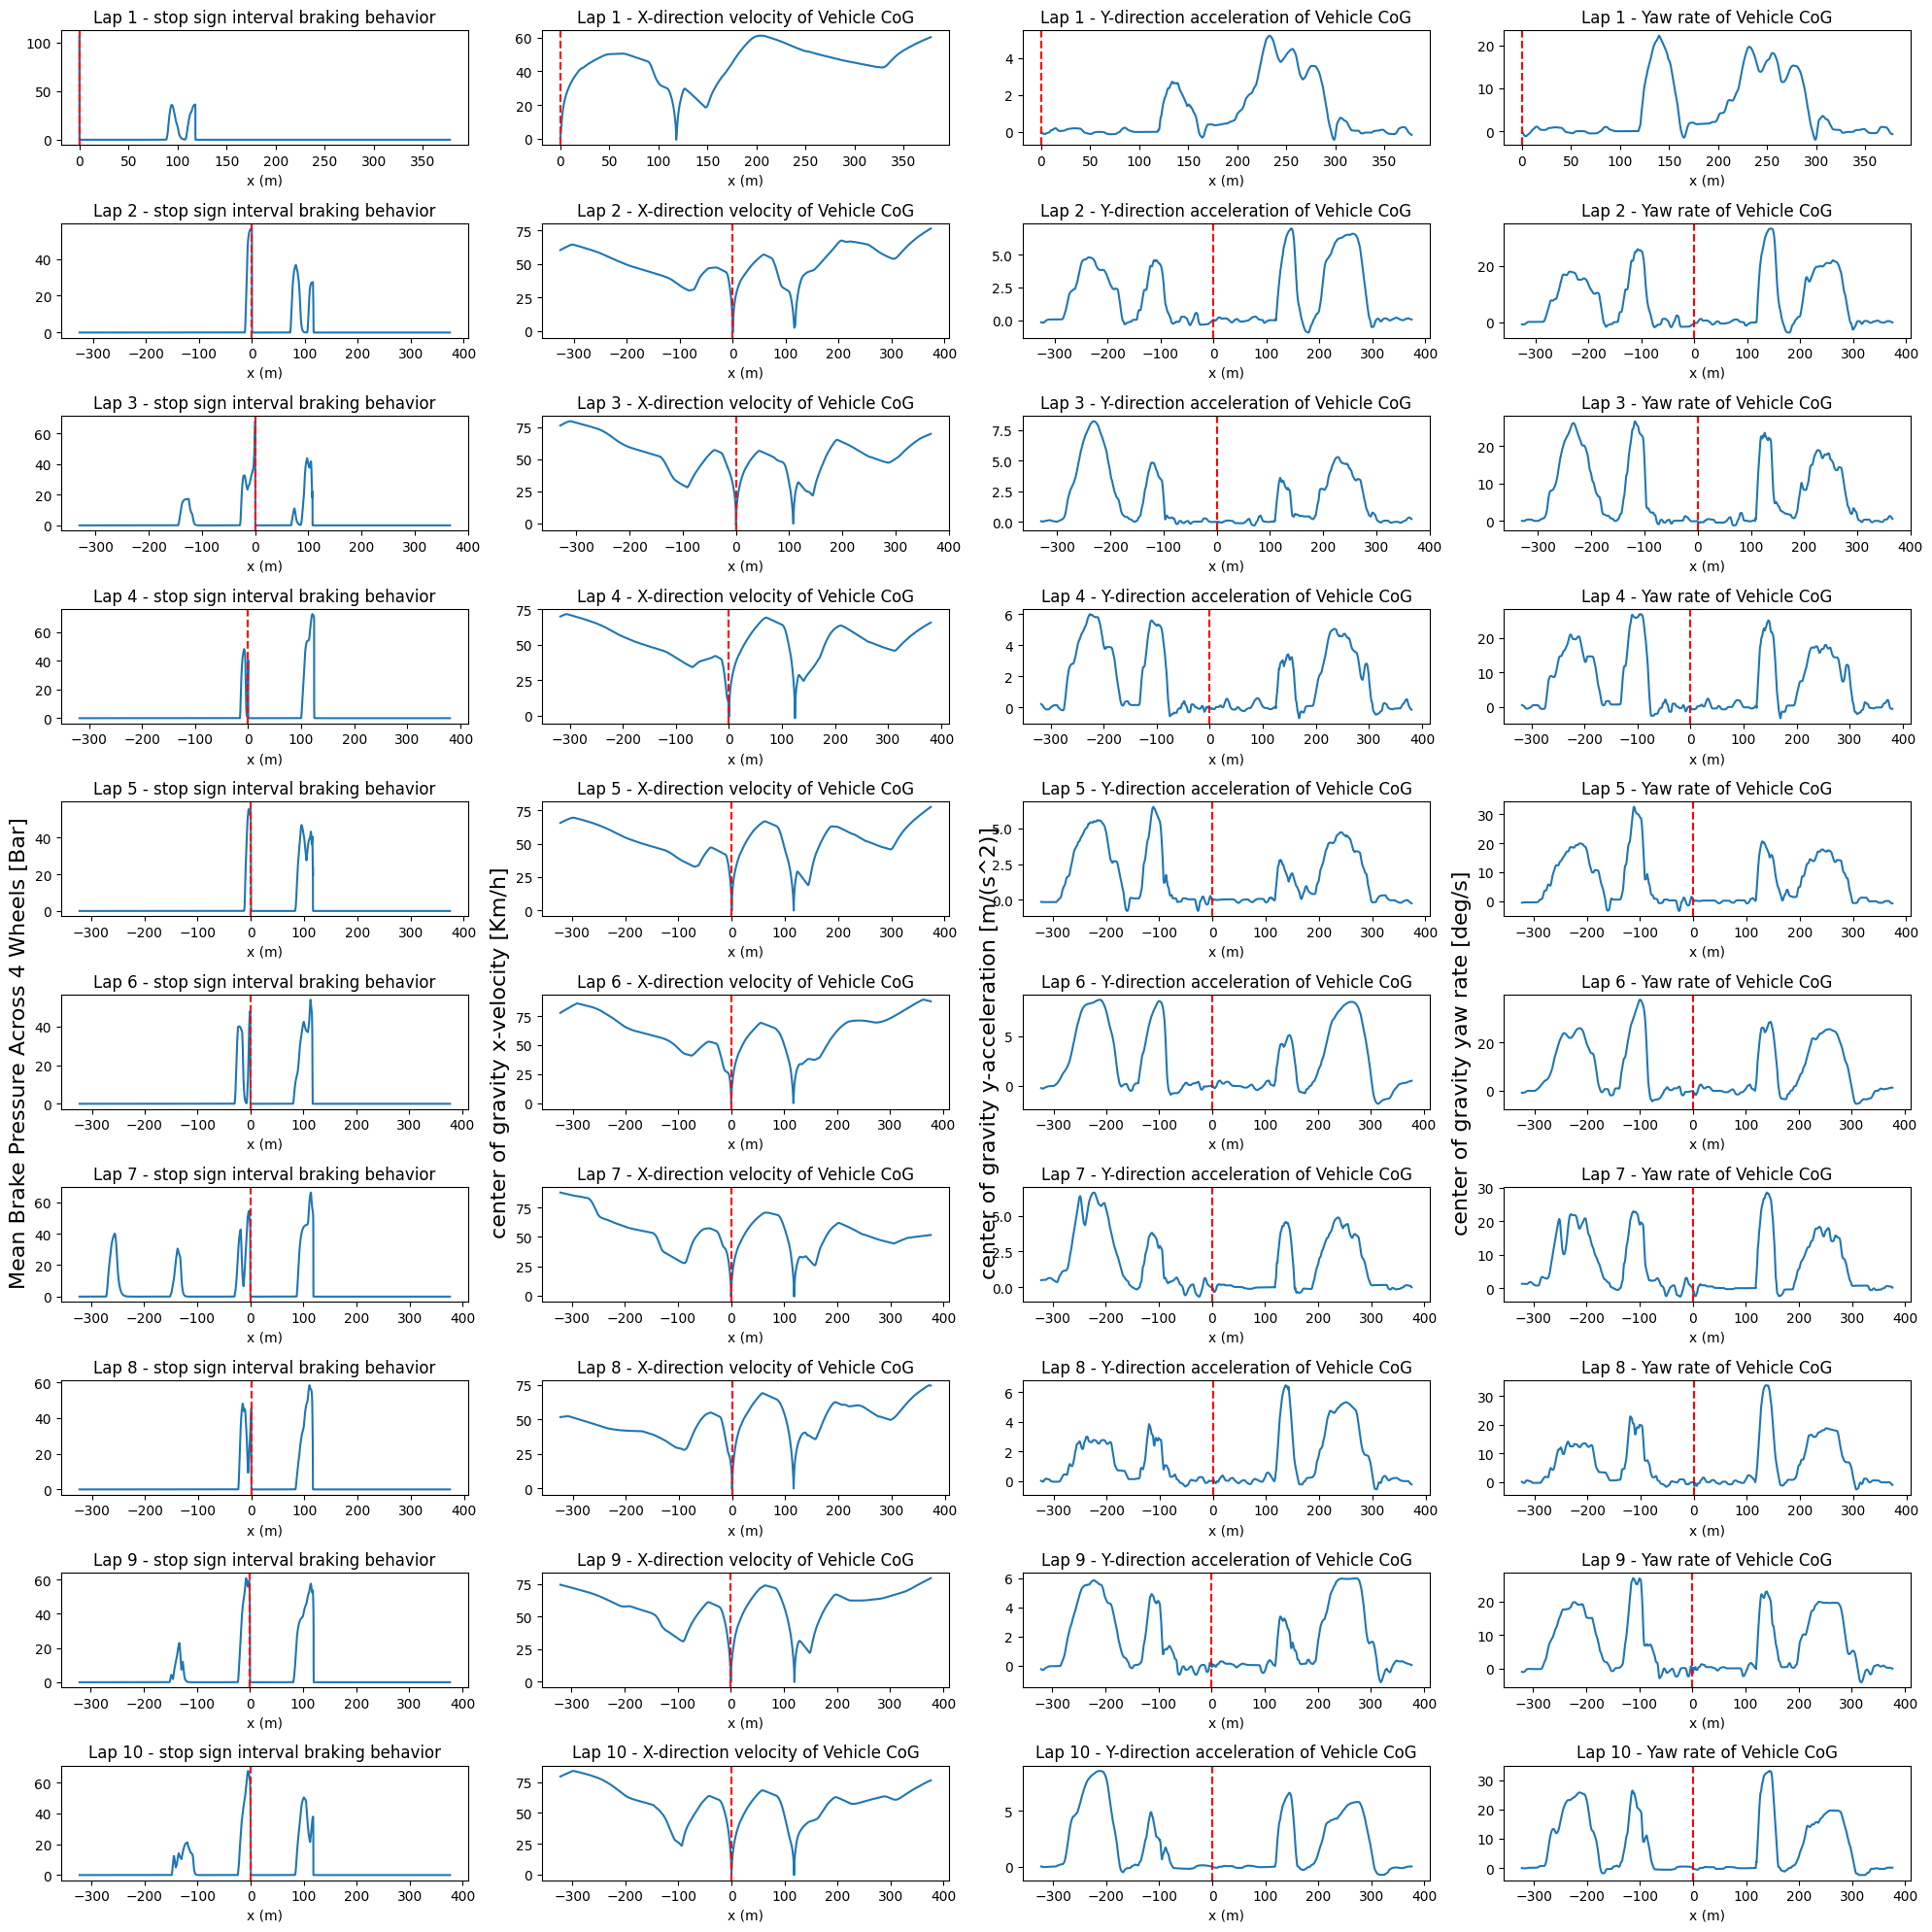

In [7]:
column_labels = ['Brake[Bar]_avg', 'a_y_Vehicle_CoG[m|s2]', 'YawRate_Vehicle_CoG[deg|s]', 'v_x_Vehicle_CoG[km|h]']


fig, axs = plt.subplots(N_LAPS, len(column_labels), figsize=(20, 20))

for i in range(N_LAPS):
    
    # lap interval
    start_idx, end_idx = lap_idx[i][0], lap_idx[i][1]
    gaze_start_idx, gaze_end_idx = gaze_lap_idx[i][0], gaze_lap_idx[i][1]
    norm_idx = find_stop_point(df_vehicle, start_idx, end_idx, e=0.5) # normalization w.r.t. speed < e
    print("Normalized index:", norm_idx)
    # ts_vehicle = df_vehicle['time_real'].iloc(norm_idx)
    # gaze_norm_idx = gaze.find_closest_ts_idx(ts_vehicle)
    
    # sectioned interval. (e.g., turning corner, section before/after stop sign, etc.)
    start_idx, end_idx = section_idx(start_idx, end_idx)
    gaze_start_idx, gaze_end_idx = section_idx(gaze_start_idx, gaze_end_idx)

    x = df_vehicle['s'][start_idx:end_idx] - df_vehicle['s'][norm_idx]

    print(f"Lap {i+1}: {df_vehicle['s'][norm_idx]}")
    # print(x)

    # Column data
    brake_pressure = df_vehicle['Brake[Bar]_avg'][start_idx:end_idx]
    v_x            = df_vehicle['v_x_Vehicle_CoG[km|h]'][start_idx:end_idx]
    a_y            = df_vehicle['a_y_Vehicle_CoG[m|s2]'][start_idx:end_idx]
    yaw            = df_vehicle['YawRate_Vehicle_CoG[deg|s]'][start_idx:end_idx]
    vline          = 0 # df_vehicle['x'][norm_idx]

    # Plot brake pressure
    axs[i, 0].plot(x, brake_pressure, label=f'Lap {i+1}')
    axs[i, 0].set_title(f'Lap {i+1} - stop sign interval braking behavior')
    axs[i, 0].axvline(x=vline, color='red', linestyle='--')
  
    # Plot velocity
    axs[i, 1].plot(x, v_x, label=f'Lap {i+1}')
    axs[i, 1].set_title(f'Lap {i+1} - X-direction velocity of Vehicle CoG')
    axs[i, 1].axvline(x=vline, color='red', linestyle='--')

    # Plot acceleration
    axs[i, 2].plot(x, a_y, label=f'Lap {i+1}')
    axs[i, 2].set_title(f'Lap {i+1} - Y-direction acceleration of Vehicle CoG')
    axs[i, 2].axvline(x=vline, color='red', linestyle='--')

    #Plot Yaw rate
    axs[i, 3].plot(x, yaw, label=f'Lap {i+1}')
    axs[i, 3].set_title(f'Lap {i+1} - Yaw rate of Vehicle CoG')
    axs[i, 3].axvline(x=vline, color='red', linestyle='--')

    # Set common labels
    for j in range(len(column_labels)):
        axs[i, j].set_xlabel('x (m)')

    print()

axs[5, 0].set_ylabel('Mean Brake Pressure Across 4 Wheels [Bar]', fontsize = 16)
axs[5, 1].set_ylabel('center of gravity x-velocity [Km/h]', fontsize = 16)
axs[5, 2].set_ylabel('center of gravity y-acceleration [m/(s^2)]', fontsize = 16)
axs[5, 3].set_ylabel('center of gravity yaw rate [deg/s]', fontsize = 16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Time domain normalization

Normalized index: 14364
Before: 0 57456
After: 0 57456

ts: 110.2252987
ts: 110.22607749997405
Normalized index: 83706
Before: 57457 117900
After: 57457 117900

ts: 179.4449351
ts: 179.44353649998084
Normalized index: 141374
Before: 117901 176634
After: 117901 176634

ts: 243.232088
ts: 243.23245999997016
Normalized index: 201602
Before: 176635 236026
After: 176635 236026

ts: 311.758454
ts: 311.7597395000048
Normalized index: 260437
Before: 236027 295277
After: 236027 295277

ts: 380.4257901
ts: 380.42337450000923
Normalized index: 316508
Before: 295278 347358
After: 295278 347358

ts: 445.6648226
ts: 445.66411750001134
Normalized index: 370472
Before: 347359 406069
After: 347359 406069

ts: 507.5392649
ts: 507.53428849997
Normalized index: 435181
Before: 406070 469455
After: 406070 469455

ts: 582.7663484
ts: 582.7651324999752
Normalized index: 492228
Before: 469456 524573
After: 469456 524573

ts: 648.119042
ts: 648.1200349999708
Normalized index: 546403
Before: 524574 578918
After:

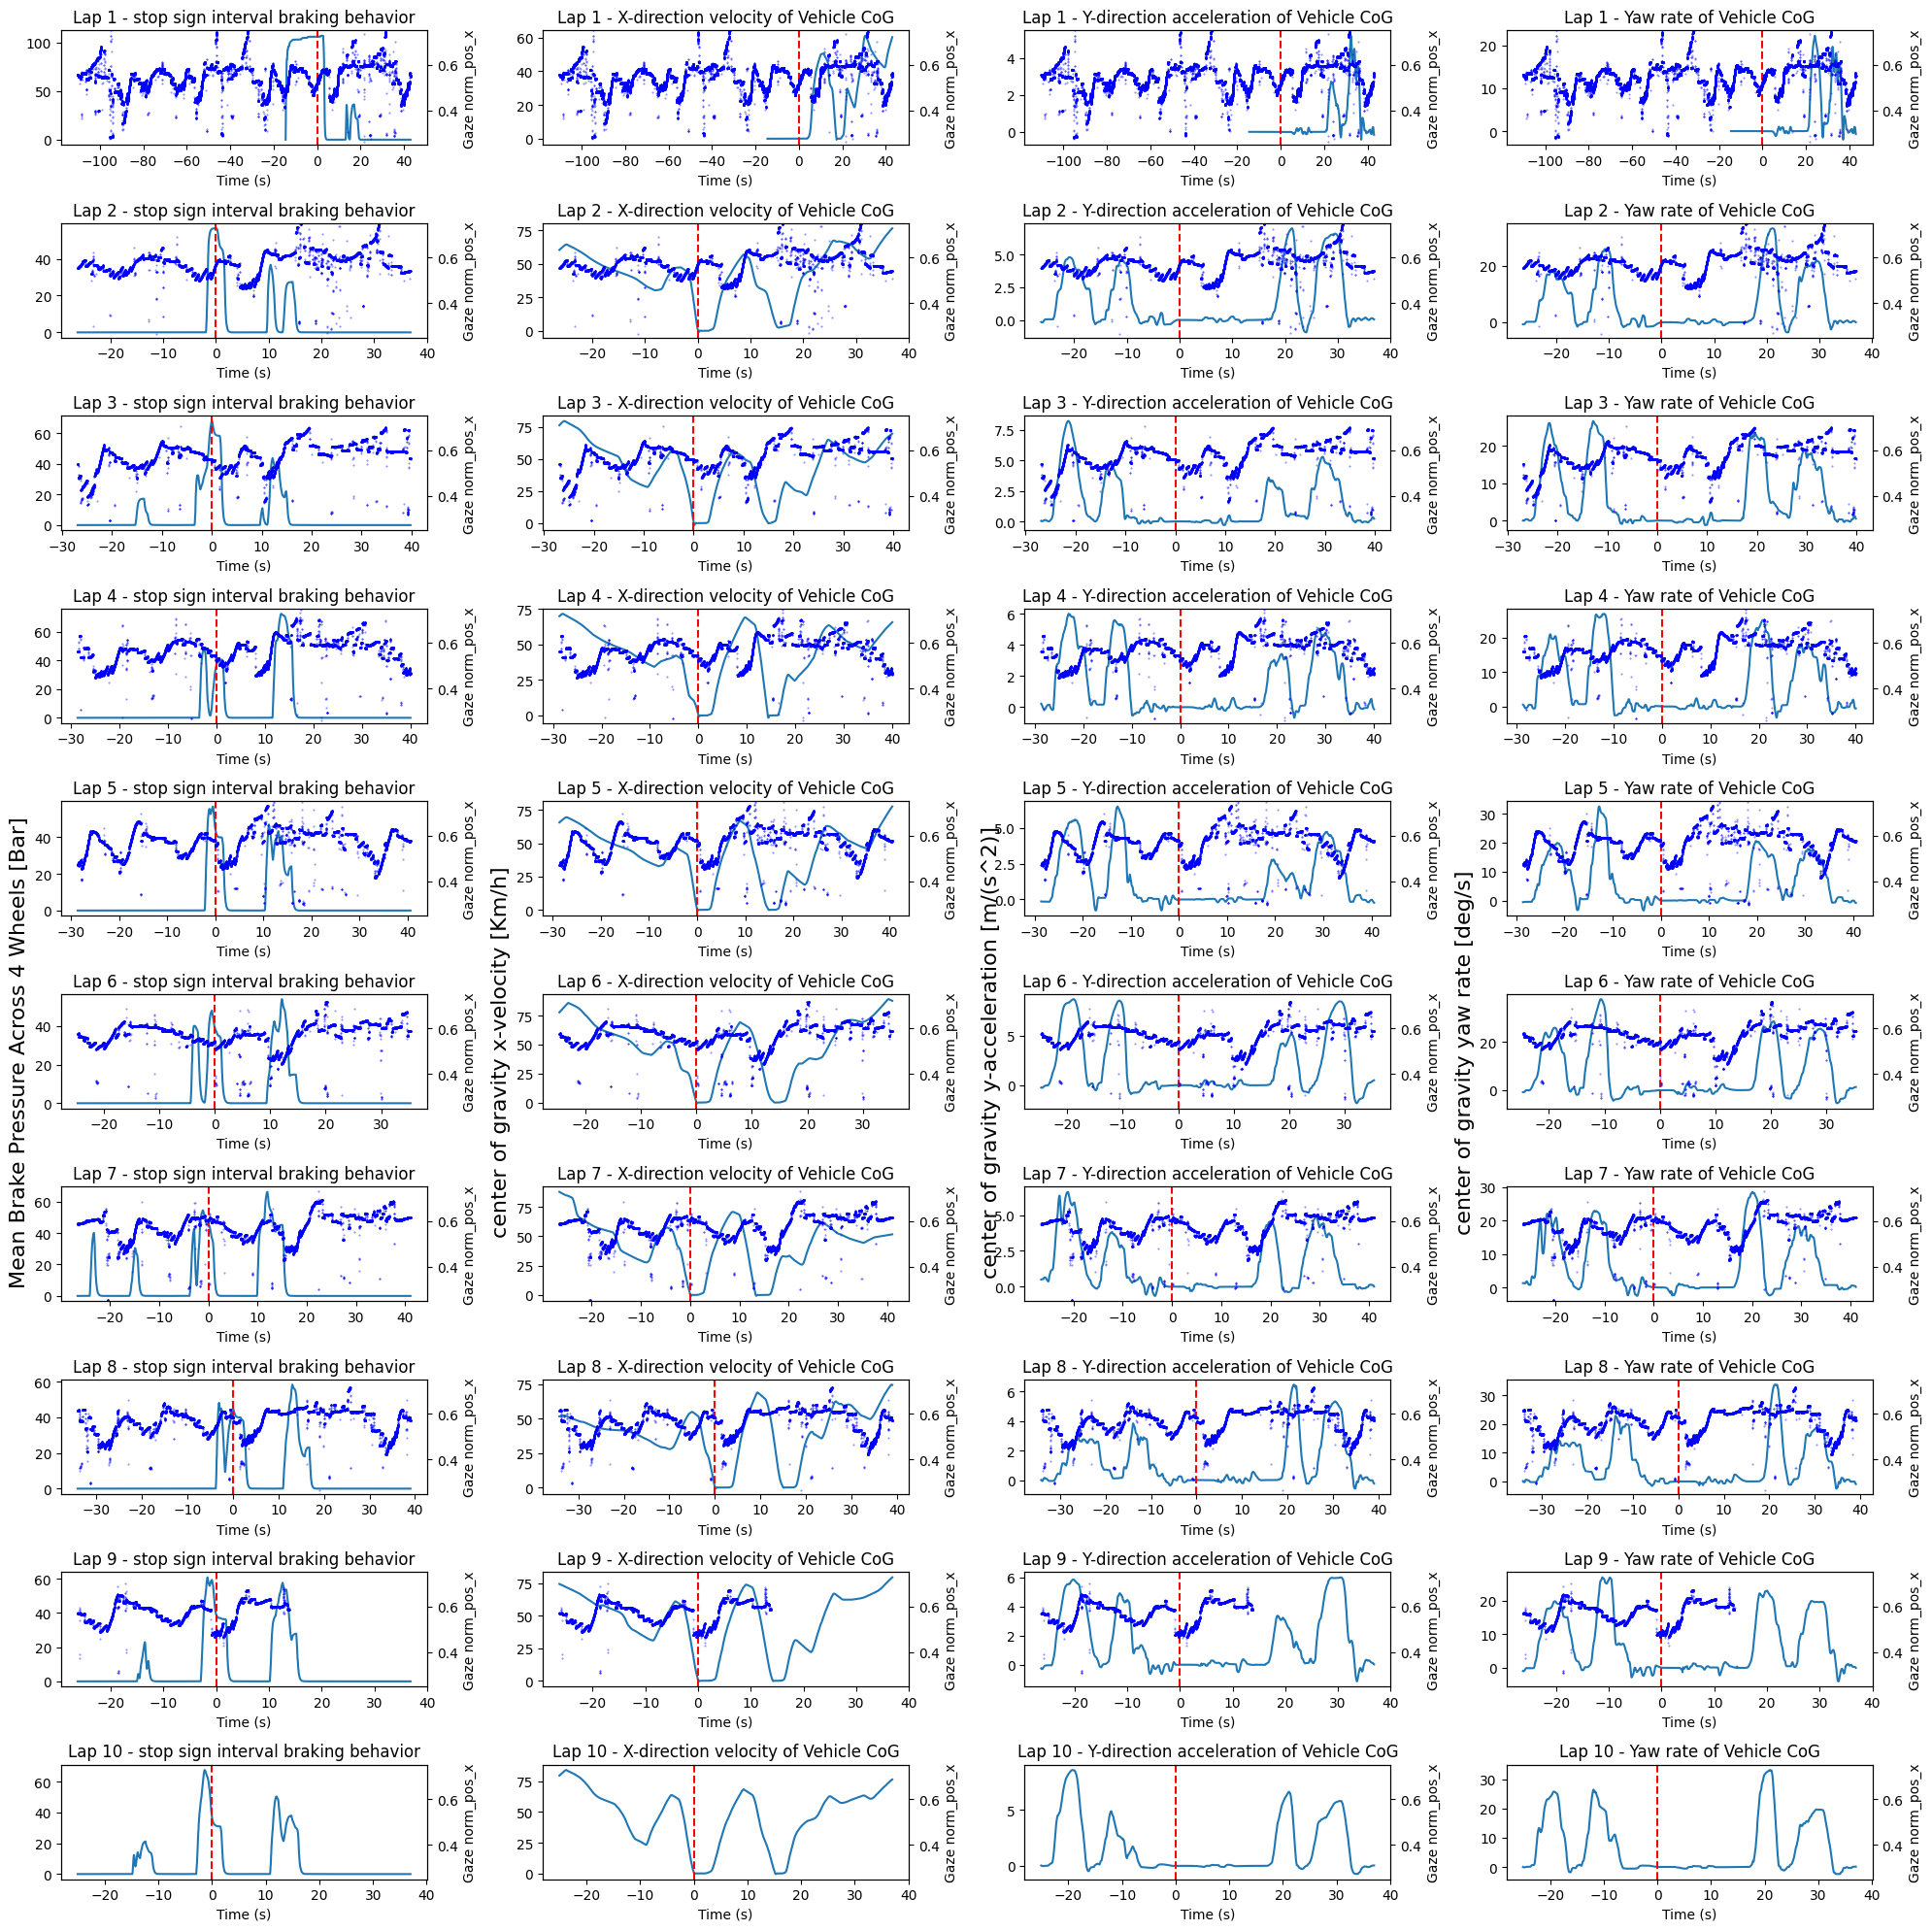

In [8]:
column_labels = ['Brake[Bar]_avg', 'a_y_Vehicle_CoG[m|s2]', 'YawRate_Vehicle_CoG[deg|s]', 'v_x_Vehicle_CoG[km|h]']


fig, axs = plt.subplots(N_LAPS, len(column_labels), figsize=(20, 20))

for i in range(N_LAPS):
    
    # lap interval
    start_idx, end_idx = lap_idx[i][0], lap_idx[i][1]
    gaze_start_idx, gaze_end_idx = gaze_lap_idx[i][0], gaze_lap_idx[i][1]
    norm_idx = find_stop_point(df_vehicle, start_idx, end_idx, e=0.5) # normalization w.r.t. speed < e
    
    print("Normalized index:", norm_idx)
    ts_vehicle = df_vehicle['time_real'][norm_idx]
    gaze_norm_idx = gaze.find_closest_ts_idx(ts_vehicle)
    
    # sectioned interval. (e.g., turning corner, section before/after stop sign, etc.)
    print("Before:", start_idx, end_idx)
    start_idx, end_idx = section_idx(start_idx, end_idx)
    print("After:", start_idx, end_idx)
    gaze_start_idx, gaze_end_idx = section_idx(gaze_start_idx, gaze_end_idx)
    print()
    
    # grab gaze data
    print("ts:", df_vehicle['time_real'][norm_idx])
    print("ts:", df_gaze['gaze_timestamp'][gaze_norm_idx])
    time = df_vehicle['time_real'][start_idx:end_idx] - df_vehicle['time_real'][norm_idx]
    gaze_time = df_gaze['gaze_timestamp'][gaze_start_idx:gaze_end_idx] - df_gaze['gaze_timestamp'][gaze_norm_idx]

    # Column data
    brake_pressure = df_vehicle['Brake[Bar]_avg'][start_idx:end_idx]
    v_x            = df_vehicle['v_x_Vehicle_CoG[km|h]'][start_idx:end_idx]
    a_y            = df_vehicle['a_y_Vehicle_CoG[m|s2]'][start_idx:end_idx]
    yaw            = df_vehicle['YawRate_Vehicle_CoG[deg|s]'][start_idx:end_idx]
    vline          = 0 # df_vehicle['time_real'][norm_idx]

    # Plot variables
    YTICKS = [0.25, 0.375, 0.5, 0.625, 0.75] 

    # Plot brake pressure
    axs[i, 0].plot(time, brake_pressure, label=f'Lap {i+1}')
    axs[i, 0].set_title(f'Lap {i+1} - stop sign interval braking behavior')
    axs[i, 0].axvline(x=vline, color='red', linestyle='--')
    
    ax2 = axs[i, 0].twinx()
    norm_pos_x = df_gaze['norm_pos_x'][gaze_start_idx:gaze_end_idx]
    ax2.scatter(gaze_time, norm_pos_x, label='Gaze norm_pos_x', color='blue', s=0.2, alpha=0.5)
    ax2.set_ylabel('Gaze norm_pos_x')
    ax2.set_ylim(0.25, 0.75)
    # ax2.set_yticks(YTICKS)
  
    # Plot velocity
    axs[i, 1].plot(time, v_x, label=f'Lap {i+1}')
    axs[i, 1].set_title(f'Lap {i+1} - X-direction velocity of Vehicle CoG')
    axs[i, 1].axvline(x=vline, color='red', linestyle='--')
    ax2 = axs[i, 1].twinx()
    norm_pos_x = df_gaze['norm_pos_x'][gaze_start_idx:gaze_end_idx]
    ax2.scatter(gaze_time, norm_pos_x, label='Gaze norm_pos_x', color='blue', s=0.2, alpha=0.5)
    ax2.set_ylabel('Gaze norm_pos_x')
    ax2.set_ylim(0.25, 0.75)
    # ax2.set_yticks(YTICKS)

    # Plot acceleration
    axs[i, 2].plot(time, a_y, label=f'Lap {i+1}')
    axs[i, 2].set_title(f'Lap {i+1} - Y-direction acceleration of Vehicle CoG')
    axs[i, 2].axvline(x=vline, color='red', linestyle='--')
    ax2 = axs[i, 2].twinx()
    norm_pos_x = df_gaze['norm_pos_x'][gaze_start_idx:gaze_end_idx]
    ax2.scatter(gaze_time, norm_pos_x, label='Gaze norm_pos_x', color='blue', s=0.2, alpha=0.5)
    ax2.set_ylabel('Gaze norm_pos_x')
    ax2.set_ylim(0.25, 0.75)
    # ax2.set_yticks(YTICKS)

    #Plot Yaw rate
    axs[i, 3].plot(time, yaw, label=f'Lap {i+1}')
    axs[i, 3].set_title(f'Lap {i+1} - Yaw rate of Vehicle CoG')
    axs[i, 3].axvline(x=vline, color='red', linestyle='--')
    ax2 = axs[i, 3].twinx()
    norm_pos_x = df_gaze['norm_pos_x'][gaze_start_idx:gaze_end_idx]
    ax2.scatter(gaze_time, norm_pos_x, label='Gaze norm_pos_x', color='blue', s=0.2, alpha=0.5)
    ax2.set_ylabel('Gaze norm_pos_x')
    ax2.set_ylim(0.25, 0.75)
    # ax2.set_yticks(YTICKS)
    

    # Set common labels
    for j in range(len(column_labels)):
        axs[i, j].set_xlabel('Time (s)')

axs[5, 0].set_ylabel('Mean Brake Pressure Across 4 Wheels [Bar]', fontsize = 16)
axs[5, 1].set_ylabel('center of gravity x-velocity [Km/h]', fontsize = 16)
axs[5, 2].set_ylabel('center of gravity y-acceleration [m/(s^2)]', fontsize = 16)
axs[5, 3].set_ylabel('center of gravity yaw rate [deg/s]', fontsize = 16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()